In [1]:
from scipy import signal
import numpy as np
import matplotlib.pylab as plt

## Estimating time series

Text(0, 0.5, 'Amplitude')

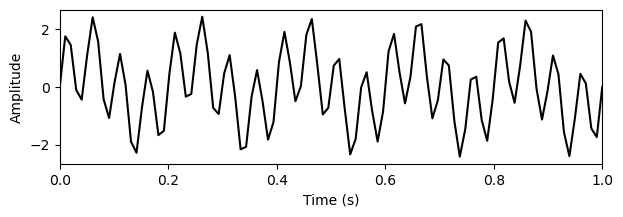

In [22]:
fs = 100  # sampling rate 
t = np.linspace(0, 1, fs)  # time
freq1 = 5 
freq2 = 20 

# 時間域訊號
signal = np.sin(2 * np.pi * freq1 * t) + 1.5 * np.sin(2 * np.pi * freq2 * t)

plt.figure(figsize=(7,2))
plt.plot(t, signal, 'k')
plt.xlim(0,1)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

## adding some note
* fft
* Nyquist Frequency


Text(0.5, 0, 'Frequency (Hz)')

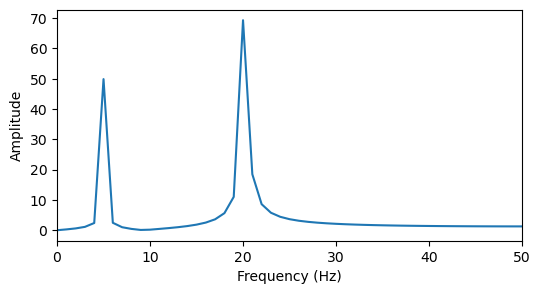

In [28]:
fNy = fs/ 2 
npts = len(t)

spec = np.fft.rfft(signal)
freq = np.linspace(0, fs/2, npts // 2 + 1)

plt.figure(figsize=(6,3))
plt.plot(freq, abs(spec))
plt.xlim(0, fNy)
plt.ylabel('Amplitude')
plt.xlabel('Frequency (Hz)')

##### References:
* https://seismo-live.github.io/html/Signal%20Processing/fourier_transform_solution_wrapper.html
* https://hackmd.io/@sysprog/fourier-transform